# Scikit Learn

We continue exploring the richness of scikit-learn for data science.  In this presentation, we look at dimensionality reduction.

**Note on Cloud Servers**  
1. Microsoft Azure Free Notebooks - Didn't work with some obscure internal error.
2. Kaggle Kernels.  Encountered the Achiles Heel of Kaggle - Cannot download data through urlopen.  That means a lot of typically data packages won't work on Kaggle.

# First - An Overview from 30,000 Feet

Let's get some perspective.  Here are two views of the data science landscape.  The first gives some ideas about how to attack solving a data science problem.

![](https://raw.githubusercontent.com/jeffreyrnorton/Notebooks_MachineLearning/master/images/Images2F22223C096-19r.jpg)

The second is good gives some more details on particular techniques.

![](https://raw.githubusercontent.com/jeffreyrnorton/Notebooks_MachineLearning/master/images/Images2F2222364632-3r.jpg)

# Dimensionality Reduction

### What is it?

Given a problem with $p$ features, can we find $k$, $k < p$ features which still capture the variation in the model - the "richness" of the model?

### Why do we care?

Because a less complex model is both easier to understand and solve.  This includes visualization of the model.  For example, if I have a classification model with 300 features, how do I visualize the output?

**But - we also have to concern ourselves with "the curse of dimensionality"!**  (Bellman - 1961)

## The Curse of Dimensionality

The motivation for dimension reduction is the *curse of dimensionality*.  The curse of dimensionality applies to both modeling and data modeling.

To obtain a more accurate classification, we can add more features. Perhaps we can obtain a perfect classification by carefully defining a few hundred features? The answer to this question might sound a bit counter-intuitive: no we can not! In fact, after a certain point, increasing the dimensionality of the problem by adding new features degrades the performance of our classifier. This is illustrated by figure 1, and is often referred to as ‘The Curse of Dimensionality’.

![](http://www.visiondummy.com/wp-content/uploads/2014/04/dimensionality_vs_performance.png)

**Example**

Consider the classification problem for cats and dogs.  One feature is not enough.
![](http://www.visiondummy.com/wp-content/uploads/2014/04/1Dproblem.png)
Add a second feature.  Still, no single boundary will effectively separate the cats and dogs.
![](http://www.visiondummy.com/wp-content/uploads/2014/04/2Dproblem.png)
Add a third feature.  This time, we can effectively separate the cats and dogs with a linear combination of the three features.
![](http://www.visiondummy.com/wp-content/uploads/2014/04/3Dproblem_separated.png)
Using too many features results in *overfitting*. The classifier starts learning exceptions that are specific to the training data and do not generalize well when new data is encountered.
![](http://www.visiondummy.com/wp-content/uploads/2014/04/overfitting.png)

**Nearest Neigbor in p dimensions**

In the nearest neighbor problem we seek to define a $p$-dimensional hypercube around a point which contains a fraction $r$ of the total number of points.  The expected edge length of the hypercube is

$e_p(r) = r^{\frac{1}{p}}$

Consider $p=3$ and with r = 0.01 (1%) and r = 0.10 (10%):

$e_3(0.01)$ = 0.21 or 21%  
$e_3(0.10)$ = 0.46 or 46%

That is already a pretty high percentage of the cube to include just 10% of the samples around a single cluster.  Now consider ten features - the ten-dimensional hypercube:

$e_{10}(0.01)$ = 0.63 or 63%  
$e_{10}(0.10)$ = 0.80 or 80%

That is hardly local.  To guarantee capturing 10% of the samples in 10-dimensional space, 80% of the hypercube must be covered.

A little visualization with the help of our cats and dogs - at 20% sample size we get

![](http://www.visiondummy.com/wp-content/uploads/2014/04/curseofdimensionality.png)

If we apply the 70/30 rule - that is, 70% for training and 30% for testing, then in 10 dimensions

$e_{10}(0.70)$ = 0.96 or 96% of the hypercube must be covered.

**Sparse Sampling in High Dimensions**

Another manifestation of the curse is the distance of any data point from the boundary of the sample. Consider $N$ data points uniformly distributed in a $p$-dimensional unit ball.  For the nearest-neighbor estimate, the median distance of the closest data point to the origin of the unit ball is

$d(p,N) = \bigg( 1 - \frac{1}{2}^{\frac{1}{N}}\bigg)^{\frac{1}{p}}$

For $p = 3$ and a sample size $N = 500$:

$d(3,500)$ = 0.11

but for $p=10$ with the same sample size:

$d(10,500)$ = 0.52

That is for $p=10$ most points in the sample are closer to the boundary of the sample space than to any other data point.  The reason this is a problem is that prediction is more difficult near the boundary of the training sample.  It is necessary to extrapolate from neighboring sample points rather than interpolate between them.

#### References
[The Curse of Dimensionality in classification](http://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/)   
Hastie et al, The Elements of Statistical Learning: Data Mining, Inference, and Prediction, Second Edition, 2016.



In [1]:
import math, random
import numpy as np
import sklearn as sk
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt

%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

## Principal Component Analysis (PCA)

To understand PCA, we will approach it geometrically.  Consider an ellipsoid with the following parametric definitions.

$x = a cos(\theta) cos(\phi)$  
$y = b cos(\theta) sin(\phi)$  
$z = c sin(\theta)$  
where  
$-\frac{\pi}{2} \le theta \le \frac{\pi}{2}$  
$-\pi \le phi \le \pi$

Define functions to help us out.

In [2]:
def xc(a, theta, phi):
    return a*math.cos(theta)*math.cos(phi)
def yc(b, theta, phi):
    return b*math.cos(theta)*math.sin(phi)
def zc(c, theta):
    return c*math.sin(theta)

In [3]:
def thetac():
    return random.randrange(start=-10000, stop=10000)/10000.0 * math.pi/2

def phic():
    return random.randrange(start=-10000, stop=10000)/10000.0 * math.pi

In [4]:
def ivalue(x,y,z):
    ix = x+y+z
    return("%.4f" % round(ix,4))

def ellipsoid(a, b, c, npoints=100, pinternal=0.70):
    xs, ys, zs = [], [], []
    index = []
    for i in range(0,npoints*2):
        theta, phi = thetac(), phic()
        x, y, z = xc(a, theta, phi), yc(b, theta, phi), zc(c, theta)
        ix = ivalue(x,y,z)
        if ix not in index:
            xs.append(x)
            ys.append(y)
            zs.append(z)
            index.append(ix)
            if len(xs) >= (1.0-pinternal)*npoints:
                break
                
    # Process internal points
    bcount = len(xs)
    for i in range(0, npoints*2):
        i1, i2 = random.randint(0,bcount-1), random.randint(0,bcount-1)
        uu = random.uniform(0.0000001, 0.9999999)
        x = xs[i1] + uu * (xs[i2] - xs[i1])
        y = ys[i1] + uu * (ys[i2] - ys[i1])
        z = zs[i1] + uu * (zs[i2] - zs[i1])
        xs.append(x)
        ys.append(y)
        zs.append(z)
        if len(xs) == npoints:
            break

    return np.array((xs, ys, zs))

### Example - Fat Disc


Eigenvalues = [ 0.22957795  0.17721919  0.00092951]


,0,1,2
0,0.388186,0.921573,0.003845
1,0.921574,-0.388196,0.002309
2,-0.003620,-0.002647,0.999990


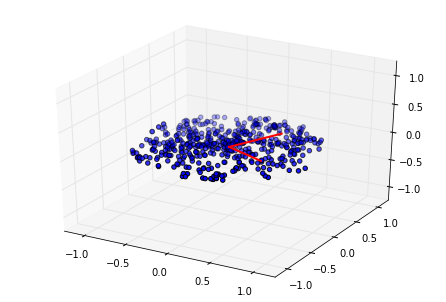

In [5]:
# Calculate x,y,z points.
disc = ellipsoid(a=1.0, b=1.0, c=0.05, npoints=500)

# Calculate Eigenvalue e and the Eigenvectors v.
cov1 = np.cov(disc)
e2, v2 = np.linalg.eig(cov1)
print('Eigenvalues = {}'.format(e2))
display(pd.DataFrame(v2))

# Set up the plot
fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlim3d(-1.2, 1.2)
ax.set_ylim3d(-1.2, 1.2)
ax.set_zlim3d(-1.2, 1.2)

# Add axes along the eigenvectors (at proper scale)
for e_, v_ in zip(e2, v2.T):
    ax.plot([0, 3*e_*v_[0]], [0, 3*e_*v_[1]], 'r-', lw=2)

# Add the points to the scatter plot.
ax.scatter(disc[0,:], disc[1,:], disc[2,:])

### Example. "Cigar"

Eigenvalues = [ 0.19592254  0.00224832  0.00098663]


,0,1,2
0,0.999976,-0.006516,-0.002325
1,-0.003091,-0.120200,-0.992745
2,-0.006190,-0.992728,0.120217


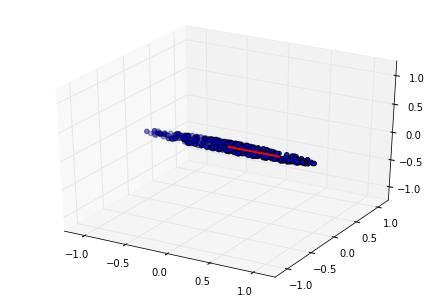

In [6]:
# Calculate x,y,z points.
cigar = ellipsoid(a=1.0, b=0.075, c=0.075, npoints=500)

# Calculate Eigenvalue e and the Eigenvectors v.
cov1 = np.cov(cigar)
e3, v3 = np.linalg.eig(cov1)
print('Eigenvalues = {}'.format(e3))
display(pd.DataFrame(v3))

# Set up the plot
fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlim3d(-1.2, 1.2)
ax.set_ylim3d(-1.2, 1.2)
ax.set_zlim3d(-1.2, 1.2)

# Add axes along the eigenvectors (at proper scale)
for e_, v_ in zip(e3, v3.T):
    ax.plot([0, 3*e_*v_[0]], [0, 3*e_*v_[1]], 'r-', lw=2)

# Add the points to the scatter plot.
ax.scatter(cigar[0,:], cigar[1,:], cigar[2,:])

# Principal Component Analysis
Principal Components Analysis (PCA) calculates and ranks all the eigenvalues and eigenvectors of a covariance matrix. This is useful because high-dimensional data (with p features) may have nearly all their variation in a small number of dimensions k. The most variation in the k dimensions will be in the subspace spanned by the eigenvectors of the covariance matrix that have the k largest eigenvalues. By projecting the original data into this subspace, we can reduce the dimensions (from p to k) with hopefully little loss of information.

Numerically, PCA is typically done using SVD on the data matrix rather than eigendecomposition on the covariance matrix.

Essentially, we have already shown PCA above, but it is easier with scikit-learn.

### Reference
[Applications of Linear Alebra: PCA](http://people.duke.edu/~ccc14/sta-663-2016/09_PCA.html).  
[PCA in Six Steps](https://coolstatsblog.com/2015/03/21/principal-component-analysis-explained/)  
[Sklearn Documentation for PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

## A Few Cool Bits and PCA

### Data Normalization

SKlearn has a slick routine for [normalizing data](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html).

### What is SVD and Why is it used?

SVD stands for Singular-Value Decomposition.  What is decomposition?

Decomposition is a technique by which a matrix is factorized into a product of matrices.  The best known of these is LU (Lower Upper) decomposition.  In LU decomposition, a matrix is factorized into a lower (L) and upper (U) triangular matrics ($L$ has ones on the diagonal, $U$ does not).

Define the solution of a set of linear equations as

$Ax = b$

where $A$ is an $n x n$ array of coefficients, $b$ is a vector of $n$ responses and $x$ is an unknown vector of $n$ values to find.  We can write the equation as

$LUx = b$

To solve for $x$ we can break the problem into two steps.  
1. Find $y$ such that $Ly = b$.
2. Find $x$ such that $Ux = y$.

This approach is extremely efficient computationally.  Another decomposition is called an eigendecomposition in which case the factorization takes the form $A = Q  \Lambda Q^{-1}$ from which eigenvalues and eigenvectors may be easily calculated.

But one issue with many of these decompositions is that they require that the matrices be full rank.  That means that every row in the matrix is linearly independent.  What that means is that no data point can be a multiple of another.  This can be a serious issue when dealing with very large data sets where there may be duplicate or near-duplicate points.

The way around this is to use the Singular-Value Decomposition which takes the form $A = U \Sigma V^{*}$.  SVD operates on any $m x n$ complex array.  Furthermore, the formulation is such that the eigenvalues and eigenvectors used for PCA are readily calculated.  See [Cross-Validated](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca).

### Applying PCA

Scikit Learn's PCA algorithm takes care of the math for us.  The biggest difficulty is in interpreting the results.  That is why we are looking at a sphere (3-dimensional), disc (can "squish" to 2-dimensional) and cigar (can "squish" to 1-dimensional).  It allows us to consider the different measures and see how they indicate how we can reduce dimensions.

In [7]:
from sklearn.decomposition import PCA

for geometry, label in [(disc, "Disc"), (cigar, "Cigar")]:

    for dimension in [3,2,1]:
        pca = PCA(n_components=dimension)
    
        pca.fit(geometry)
        #PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
        #  svd_solver='auto', tol=0.0, whiten=False)
        if dimension == 3:
            print('{} at PCA Dimension      : {}'.format(label, dimension))
            print('Explained Variance Ratio : {}'.format(pca.explained_variance_ratio_))
            print('Explained variance       : {}'.format(pca.explained_variance_))
            print('')

Disc at PCA Dimension      : 3
Explained Variance Ratio : [  7.20010365e-01   2.79989635e-01   8.46540683e-32]
Explained variance       : [  3.19151849e+01   1.24108227e+01   3.75237688e-30]

Cigar at PCA Dimension      : 3
Explained Variance Ratio : [  9.89136784e-01   1.08632161e-02   8.36719250e-32]
Explained variance       : [  2.22377496e+01   2.44226565e-01   1.88111022e-30]



To determine how many components to use, we can look at the magnitudes of the variance ratios.  For the cigar, it does appear that we can drop two dimensions.  For the disc, it is pretty clear that one dimension can be dropped.

# Manifold Learning

Reviewing PCA, we note that while PCA reduces dimensions, it does so in the Euclidean space $\Re^n$, that is - PCA is the process of identifying the $k$ parameters which have significant eigenvalues for $k \le n$ for $\Re^n$.

But what if we could choose some region, some curved surface on which the points reside?

In general, some r-dimensional surface (with certain properties) in some m-space ($r \le n$) is called a manifold.  Examples include a line in either $\Re^2$ or $\Re^3$, a plane or cylinder in $\Re^3$.  You can get a lot more information at [Wikipedia](https://en.wikipedia.org/wiki/Manifold).

To get a notion about Manifold Learning, let's take a look at a Sammon mapping problem.

In Sammon mapping (Sammon, 1969), we map an $n$-dimensional space into a $k$-dimensional manifold ($k < n$) preserving the distances between the points in the space.  This is done by minimizing the Sammon stress function:

$E = \frac{1}{\sum_{i<j} d^*_{ij}} \sum_{i<j} \frac{(d^*_{ij} - d_{ij})^2}{d_{ij}}$

where $d^*_{ij}$ is the distance between the $i^{th}$ and $j^{th}$ objects in the original space and $d_{ij}$ is the distance on the lower-dimensional manifold.

![](https://raw.githubusercontent.com/jeffreyrnorton/Notebooks_MachineLearning/master/images/SammonCylinder1.jpg)  

![](https://raw.githubusercontent.com/jeffreyrnorton/Notebooks_MachineLearning/master/images/SammonCylinder2.jpg)

Sammon mapping is presented here for illustrative and historical purposes.  It is not available in Scikit Learn - but is in [R](https://stat.ethz.ch/R-manual/R-devel/library/MASS/html/sammon.html).  In the next part, we consider our other options.

Scikit Learn, [Manifold Learning](http://scikit-learn.org/stable/modules/manifold.html).  
Henderson, [Sammon Mapping](http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/AV0910/henderson.pdf).  
Brucher, [Manifold Learning](http://blog.audio-tk.com/category/python/manifold-learning/).  
Brucher et al, [A Metric Multidimensional Scaling-Based Nonlinear Manifold
Learning Approach for Unsupervised Data Reduction](https://asp-eurasipjournals.springeropen.com/track/pdf/10.1155/2008/862015).

In the following code, we show how to use several manifold learning methods available in Scikit Learn.  They are documented in more detail in the [Scikit Learn documentation](http://scikit-learn.org/stable/modules/manifold.html).

*References*  
["A global geometric framework for nonlinear dimensionality reduction"](https://web.mit.edu/cocosci/Papers/sci_reprint.pdf) Tenenbaum, J.B.; De Silva, V.; & Langford, J.C. Science 290 (5500).  
[“Nonlinear dimensionality reduction by locally linear embedding”](http://www.sciencemag.org/content/290/5500/2323.full) Roweis, S. & Saul, L. Science 290:2323 (2000).  
["An Introduction to Locally Linear Embedding"](https://cs.nyu.edu/~roweis/lle/papers/lleintro.pdf) Saul, L & Roweis, S.  
[“Hessian Eigenmaps: Locally linear embedding techniques for high-dimensional data”](http://www.pnas.org/content/100/10/5591) Donoho, D. & Grimes, C. Proc Natl Acad Sci USA. 100:5591 (2003).  
MLLE: Modified Locally Linear Embedding Using Multiple Weights. Zhang, Z. & Wang, J., http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.70.382  
[“Principal manifolds and nonlinear dimensionality reduction via tangent space alignment”](http://citeseer.ist.psu.edu/viewdoc/summary?doi=10.1.1.4.3693) Zhang, Z. & Zha, H. Journal of Shanghai Univ. 8:406 (2004).   
[“Laplacian Eigenmaps for Dimensionality Reduction and Data Representation”](http://web.cse.ohio-state.edu/~mbelkin/papers/LEM_NC_03.pdf) M. Belkin, P. Niyogi, Neural Computation, June 2003; 15 (6):1373-1396.  
[Multidimensional Scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling) Wikipedia.  
[t-SNE](https://lvdmaaten.github.io/tsne/) L.J.P. van der Maaten.  
["Accelerating t-SNE using Tree-Based Algorithms"](http://jmlr.org/papers/volume15/vandermaaten14a/vandermaaten14a.pdf) L.J.P. van der Maaten. Journal of Machine Learning Research 15(Oct):3221-3245, 2014.  [Supplemental Material](https://lvdmaaten.github.io/publications/misc/Supplement_JMLR_2014.pdf)  
["Visualizing Non-Metric Similarities in Multiple Maps"](https://lvdmaaten.github.io/publications/papers/MachLearn_2012.pdf) L.J.P. van der Maaten and G.E. Hinton.  Machine Learning 87(1):33-55, 2012.  
["Learning a Parametric Embedding by Preserving Local Structure."](https://lvdmaaten.github.io/publications/papers/AISTATS_2009.pdf) L.J.P. van der Maaten. In Proceedings of the Twelfth International Conference on Artificial Intelligence & Statistics (AI-STATS), JMLR W&CP 5:384-391, 2009.  
["Visualizing High-Dimensional Data Using t-SNE"](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf) L.J.P. van der Maaten and G.E. Hinton. Journal of Machine Learning Research 9(Nov):2579-2605, 2008.  
[How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/)  

#### (2.2.2) Isomap

One of the earliest approaches to manifold learning is the Isomap algorithm, short for Isometric Mapping. Isomap can be viewed as an extension of Multi-dimensional Scaling (MDS) or Kernel PCA. Isomap seeks a lower-dimensional embedding which maintains geodesic distances between all points.

[Isomap](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html#sklearn.manifold.Isomap)

#### (2.2.3) Local Linear Embedding (LLE)
LLE seeks a lower-dimensional projection of the data which preserves distances within local neighborhoods.  It can be thought of as a series of local Principal Component Analyses which are globally compared to find the best non-linear embedding. 

[locally_linear_embedding](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.locally_linear_embedding.html#sklearn.manifold.locally_linear_embedding)  
[LocallyLinearEmbedding](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html#sklearn.manifold.LocallyLinearEmbedding)   

#### (2.2.4) Modified Locally Linear Embedding (MLLE)

One well-known issue with LLE is the regularization problem. When the number of neighbors is greater than the number of input dimensions, the matrix defining each local neighborhood is rank-deficient. To address this, standard LLE applies an arbitrary regularization parameter $r$, which is chosen relative to the trace of the local weight matrix.

[locally_linear_embedding](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.locally_linear_embedding.html#sklearn.manifold.locally_linear_embedding)  
[LocallyLinearEmbedding](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html#sklearn.manifold.LocallyLinearEmbedding)   

#### (2.2.5) Hessian Eigenmapping (Hessian LLE)

Hessian Eigenmapping (also known as Hessian-based LLE: HLLE) is another method of solving the regularization problem of LLE. It revolves around a hessian-based quadratic form at each neighborhood which is used to recover the locally linear structure.  

[locally_linear_embedding](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.locally_linear_embedding.html#sklearn.manifold.locally_linear_embedding)  
[LocallyLinearEmbedding](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html#sklearn.manifold.LocallyLinearEmbedding)   

#### (2.2.6) Spectral Embedding

Spectral Embedding is an approach to calculating a non-linear embedding. Scikit-learn implements Laplacian Eigenmaps, which finds a low dimensional representation of the data using a spectral decomposition of the graph Laplacian. The graph generated can be considered as a discrete approximation of the low dimensional manifold in the high dimensional space. Minimization of a cost function based on the graph ensures that points close to each other on the manifold are mapped close to each other in the low dimensional space, preserving local distances.

[spectral_embedding](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.spectral_embedding.html#sklearn.manifold.spectral_embedding)  
[SpectralEmbedding](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.SpectralEmbedding.html#sklearn.manifold.SpectralEmbedding)

#### (2.2.7) Local Tangent Space Alignment (LTSA)

Though not technically a variant of LLE, Local tangent space alignment (LTSA) is algorithmically similar enough to LLE that it can be put in this category. Rather than focusing on preserving neighborhood distances as in LLE, LTSA seeks to characterize the local geometry at each neighborhood via its tangent space, and performs a global optimization to align these local tangent spaces to learn the embedding.

[locally_linear_embedding](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.locally_linear_embedding.html#sklearn.manifold.locally_linear_embedding)  
[LocallyLinearEmbedding](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html#sklearn.manifold.LocallyLinearEmbedding)  

#### (2.2.8) Multi-Dimensional Scaling (MDS)

Multidimensional scaling (MDS) seeks a low-dimensional representation of the data in which the distances respect well the distances in the original high-dimensional space.

In general, MDS is a technique used for analyzing similarity or dissimilarity data. MDS attempts to model similarity or dissimilarity data as distances in a geometric spaces. The data can be ratings of similarity between objects, interaction frequencies of molecules, or trade indices between countries.

There exists two types of MDS algorithm: metric and non metric. In the scikit-learn, the class MDS implements both. In Metric MDS, the input similarity matrix arises from a metric (and thus respects the triangular inequality), the distances between output two points are then set to be as close as possible to the similarity or dissimilarity data. In the non-metric version, the algorithms will try to preserve the order of the distances, and hence seek for a monotonic relationship between the distances in the embedded space and the similarities/dissimilarities.

(Metric MDS is similar to Sammon mapping, but uses a different stress function.)

[MDS](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html#sklearn.manifold.MDS)

#### (2.2.9) t-distributed Stochastic Neighbor Embedding (t-SNE)

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. The technique can be implemented via [Barnes-Hut approximations](https://jheer.github.io/barnes-hut/), allowing it to be applied on large real-world datasets.

t-SNE converts affinities of data points to probabilities. The affinities in the original space are represented by Gaussian joint probabilities and the affinities in the embedded space are represented by Student’s t-distributions. This allows t-SNE to be particularly sensitive to local structure and has a few other advantages over existing techniques:

* Revealing the structure at many scales on a single map
* Revealing data that lie in multiple, different, manifolds or clusters
* Reducing the tendency to crowd points together at the center

While Isomap, LLE and variants are best suited to unfold a single continuous low dimensional manifold, t-SNE will focus on the local structure of the data and will tend to extract clustered local groups of samples as highlighted on the S-curve example. This ability to group samples based on the local structure might be beneficial to visually disentangle a dataset that comprises several manifolds at once as is the case in the digits dataset.

The Kullback-Leibler (KL) divergence of the joint probabilities in the original space and the embedded space will be minimized by gradient descent. Note that the KL divergence is not convex, i.e. multiple restarts with different initializations will end up in local minima of the KL divergence. Hence, it is sometimes useful to try different seeds and select the embedding with the lowest KL divergence.

The disadvantages to using t-SNE are roughly:

* t-SNE is computationally expensive, and can take several hours on million-sample datasets where PCA will finish in seconds or minutes
* The Barnes-Hut t-SNE method is limited to two or three dimensional embeddings.
* The algorithm is stochastic and multiple restarts with different seeds can yield different embeddings. However, it is perfectly legitimate to pick the embedding with the least error.
* Global structure is not explicitly preserved. This is problem is mitigated by initializing points with PCA (using init=’pca’).

[TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE)

standard: 0.29 sec
ltsa: 0.99 sec
hessian: 0.88 sec
modified: 0.6 sec
Isomap: 0.77 sec
MDS: 3.9 sec
SpectralEmbedding: 0.26 sec
t-SNE: 6.6 sec


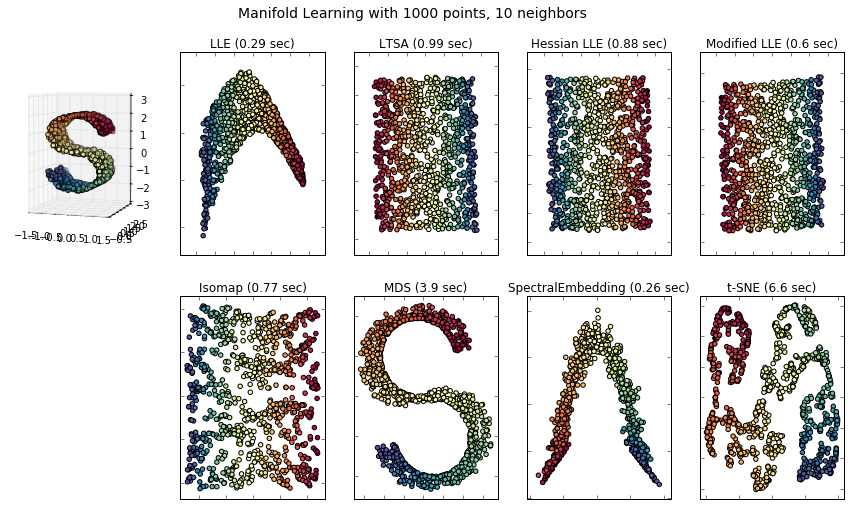

In [8]:
from time import time

from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

n_points = 1000
X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
n_neighbors = 10
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)


ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(257)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(258)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(259)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

## t-SNE for Cluster Visualization.

The following images were contributed by my coworker Hongyu Guo.  The problem being solved is how to visualize approximately 150 clusters in a 300-dimensional space.  In the following images, progressively more points are added to the data set and shown in the clusters.  t-SNE is capabable of handling tens of millions of data points.

![](https://raw.githubusercontent.com/jeffreyrnorton/Notebooks_MachineLearning/master/images/TSNE1.jpg)

![](https://raw.githubusercontent.com/jeffreyrnorton/Notebooks_MachineLearning/master/images/TSNE2.jpg)


# Latent Dirichlet Allocation

## Topic Modeling

A topic model is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents.  Intuitively, given that a document is about a particular topic, one would expect particular words to appear in the document more or less frequently: "dog" and "bone" will appear more often in documents about dogs, "cat" and "meow" will appear in documents about cats, and "the" and "is" will appear equally in both.

A document typically concerns multiple topics in different proportions; thus, in a document that is 10% about cats and 90% about dogs, there would probably be about 9 times more dog words than cat words. The "topics" produced by topic modeling techniques are clusters of similar words. A topic model captures this intuition in a mathematical framework, which allows examining a set of documents and discovering, based on the statistics of the words in each, what the topics might be and what each document's balance of topics is.

Topic models are also referred to as probabilistic topic models, which refers to statistical algorithms for discovering the *latent semantic structures* of an extensive text body.

<a href="https://en.wikipedia.org/wiki/Topic_model#Topic_models_for_context_information" target="_blank">
<img src="https://raw.githubusercontent.com/jeffreyrnorton/Notebooks_MachineLearning/master/images/Topic_model_scheme.webm.jpg" alt="Link to Topic Modeling Video">
</a>

## LDA

LDA learns how topics and documents are represented in the following form:

1. The number of topics $K$ to discover is selected. (Similar to when the number of clusters are specified for clustering algorithms).

2. Once the number of topics is selected, LDA processes each of the words in each document.  It randomly assigns the word to one of the $K$ topics. After this step we will have topic representations (how the words are distributed in each topic) and documents represented in terms of topics.

The assignment of words to topics was random - the obtained representation is not very optimal or accurate. To better this representation LDA will analyze per document:

* what is the percentage of words within the document that were assigned to a particular topic?  
* For each word in the document, LDA will analyze over all documents the percentage of times that particular word has been assigned to a particular topic.

LDA will therefore be calculating:

1. p(topic t | document d) = percentage of words in a document d that are currently assigned to topic t.  
2. p(word w | topic t) = percentage of times the word w was assigned to topic t over all documents.  

LDA will decide to move a word w from topic A to topic B when:
p(topic A | document d) * p(word w | topic A) $<$ p(topic B | document d) * p(word w |topic B)  

After a while, LDA "converges" to a more optimal state, where topic representations and documents represented in terms of these topics are ok.

#### References
[Topic Modeling](https://en.wikipedia.org/wiki/Topic_model)  
[Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)  
[Layman's Explanation of Online LDA](http://littlesaiph.blogspot.com/2012/07/laymans-explanation-of-online-lda.html)  
[LatentDirichletAllocation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)  Scikit Learn.  
[Latent Dirichlet Allocation](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) Blei et al, 2003.

The following code compares [Non-Negative Matrix Factorization (NMF)](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) to LDA.  It is left as an exercise to the reader to learn more about NMF.  What we want to do is note the apparent superiority of LDA to NMF - in fact, it seems to work very well.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Turn off truncation of column data
pd.set_option('display.max_colwidth', -1)

# Display function
def display_topics(title, model, feature_names, no_top_words):
    #df = pd.DataFrame()
    #print(type(model.components_))
    e1, e2 = [], []
    for topic_idx, topic in enumerate(model.components_):
        e1.append("P{}".format(topic_idx))
        e2.append(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    df = pd.DataFrame(list(zip(e1, e2)),
              columns=['Topic', 'Description'])
    display(HTML('<B>{}</B><br>'.format(title) + df.to_html(index=False)))


# Fetch newsgroup data.  This is the call that won't work on Kaggle.
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data

no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 20

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online',
                                learning_offset=50.,random_state=0).fit(tf)

# Display output
no_top_words = 12
display_topics('Non-Negative Matrix Factorization', nmf, tfidf_feature_names, no_top_words)
display_topics('Latent Dirichlet Allocation', lda, tf_feature_names, no_top_words)

Topic,Description
P0,don think time good did really say make way want said going
P1,card new video 00 sale monitor price offer 10 shipping cards condition
P2,edu soon cs university email internet com article ftp pub david send
P3,drive scsi drives hard disk ide controller floppy cd tape internal rom
P4,team year season players games play win teams league hockey nhl player
P5,windows file files dos window program problem using running version run screen
P6,key chip clipper encryption keys government escrow public algorithm nsa security phone
P7,car cars engine speed price good new driver bought looks insurance buy
P8,use using used work available want window widget set image software way
P9,game games hockey night play goal hit runs win shot run home


Topic,Description
P0,does think people just don believe point time case say question way
P1,gun law control guns police rate crime state laws firearms weapons second
P2,said didn did know went just came got people time left right
P3,good ve years car year just like really ago got time better
P4,use entry section code rules stuff build include int define program function
P5,windows window db using display program color screen widget motif application set
P6,israel war jews israeli men people military state women land peace rights
P7,space 000 new national research university nasa center health 1993 program april
P8,god jesus christian bible church christians faith christ life religion man true
P9,key chip encryption keys clipper use security public technology bit privacy government
